1) Зайти на сайт ЦБ РФ , в раздел курсы валют https://cbr.ru/currency_base/dynamics/
2) Получить динамику курсов корейской воны, евро и доллара за 2024 год.
3) Соединить их в одну таблицу, причем курс должен быть за каждый день, если за какой то день на сайте ЦБ нет курса, то надо взять его с прошлого дня.
4) Показать динамику курсов на одном графике, показать тренд.
5) Если удастся сделать какие то выводы, будет здорово.
Прислать питоновский код с выполненым заданием, предполагается использование стандартных библиотек – pandas + для визуализации.

In [1]:
import numpy as np
import pandas as pd

import requests
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import seaborn as  sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Для воспроизведения результатов анализа решено не привязываться к csv/xlsx файлам с данными, а напрямую парсить курсы валют через API сайта ЦБ.  
Для этого воспользуемся стандартными библиотеками requests и xml

In [2]:
# URL для запроса
start_date = '30/12/2023' # Берем не строго с 01.01.2024, чтобы актуализировать курс на новогодние выходные
end_date = '26/09/2024'
codes = {'USD': 'R01235', 'EUR': 'R01239', 'KRW': 'R01815'}

def get_dataframe(start_date, end_date, currency_code):
    url = f'https://www.cbr.ru/scripts/XML_dynamic.asp?date_req1={start_date}&date_req2={end_date}&VAL_NM_RQ={codes[currency_code]}'

    # Запрос данных
    response = requests.get(url)
    response.encoding = 'utf-8'

    # Парсим XML-ответ
    tree = ET.ElementTree(ET.fromstring(response.content))
    root = tree.getroot()

    # Извлечение данных
    data = []
    for record in root.findall('Record'):
        date = record.attrib['Date']
        value = record.find('Value').text
        data.append({'date': date, currency_code: value})

    # Преобразование в DataFrame для удобной работы
    df = pd.DataFrame(data)
    # Так как столбец с датой парсится в формате строки DD.MM.YYYY переведем его в тип datetime
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    
    return df


# Для того чтобы не пропустить ни один день с 01.01.2024 по текущую дату сгенерируем метки временного ряда с частотой в один день
df = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='d'), columns=['date'])

# Пробегаемся по валютам и джойним их по левой части к временной метке, чтобы учесть праздники и выходные
for code in codes.keys():
    dfi = get_dataframe(start_date, end_date, code)
    df = df.merge(dfi, how='left', on='date')

df

,date,USD,EUR,KRW
0,2023-12-30,"89,6883","99,1919","69,6338"
1,2023-12-31,NaN,NaN,NaN
2,2024-01-01,NaN,NaN,NaN
3,2024-01-02,NaN,NaN,NaN
4,2024-01-03,NaN,NaN,NaN
...,...,...,...,...
267,2024-09-22,NaN,NaN,NaN
268,2024-09-23,NaN,NaN,NaN
269,2024-09-24,"92,9200","103,2191","69,8699"
270,2024-09-25,"92,8622","103,4100","69,5337"


In [3]:
# Пропущена треть данных начиная с 31.12.2023 (это логично - так как ЦБ публикует данные торгов по рабочим дням, исключая выходные и праздники)
df.isna().sum() / len(df)

date    0.000000
USD     0.334559
EUR     0.334559
KRW     0.334559
dtype: float64

In [4]:
# Чтобы заполнить пропуски воспользуемся встренным методом ffill, который позволяет заполнять до тех пор пока не встретится not NaN значение
df = df.ffill()

# Отбросим два дня декабря 2023, они уже не нужны по условию задания
df = df.drop(index=df[df['date'].dt.year == 2023].index).reset_index(drop=True)
df.head()

,date,USD,EUR,KRW
0,2024-01-01,"89,6883","99,1919","69,6338"
1,2024-01-02,"89,6883","99,1919","69,6338"
2,2024-01-03,"89,6883","99,1919","69,6338"
3,2024-01-04,"89,6883","99,1919","69,6338"
4,2024-01-05,"89,6883","99,1919","69,6338"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    270 non-null    datetime64[ns]
 1   USD     270 non-null    object        
 2   EUR     270 non-null    object        
 3   KRW     270 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 8.6+ KB


In [6]:
# Данные о валютах имеют строковый тип данных, переведем их в float
df[list(codes.keys())] = df[codes.keys()].replace(',', '.', regex=True).astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    270 non-null    datetime64[ns]
 1   USD     270 non-null    float64       
 2   EUR     270 non-null    float64       
 3   KRW     270 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 8.6 KB


In [12]:
# Значение корейского вона приведено в соотношении 1000 вон = 1 рубль, для отображения в одной размерности с долларом и евро
# К слову в таком масштабе 1/1000 парсится с сайта ЦБ
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['EUR'], name='EUR'))
fig.add_trace(go.Scatter(x=df['date'], y=df['USD'], name='USD'))
fig.add_trace(go.Scatter(x=df['date'], y=df['KRW'], name='KRW'))
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                #  height=1000,
                #   width=1000
                )
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Курс: %{y:.2f}руб.')
fig.update_yaxes(title_text='руб.')

Данный график показывает сравнение динамики валют относительно рубля. Основываясь на этом графике, можно сделать следующие выводы относительно курса рубля и самих валют.

1. Рубль ослабляется относительно основных валют:
   - Евро (EUR) и доллар США (USD) в целом имеют восходящую тенденцию, что указывает на ослабление рубля в течение 2024 года. Даже при наличии краткосрочных колебаний, общее движение вверх для обеих валют указывает на снижение покупательной способности рубля по отношению к ним.
   - Южнокорейский вон (KRW) также показывает небольшие колебания, но к концу графика курс вона относительно рубля стабилизируется на чуть более высоком уровне, что опять-таки свидетельствует о слабом рубле.

2. Есть значительные колебания в июле, когда рубль временно усилился (как видно по снижению курса USD, EUR и KRW), но затем снова ослаб. Это может быть связано с:
   - Ростом цен на нефть и увеличение экспортных поступлений (углеводороды).
   - Влиянием Центрального банка и его монетарной политики (ужесточение ДКП - увеличение ключевой ставки до 18%, а после и до 19%).
   - Сезонным увеличением спроса на рубли для уплаты налогов и других внутренних потребностей (продажа выручки экспортеров).
   - Возможными политическими или спекулятивными событиями (продажа/покупка рублей ЦБ).

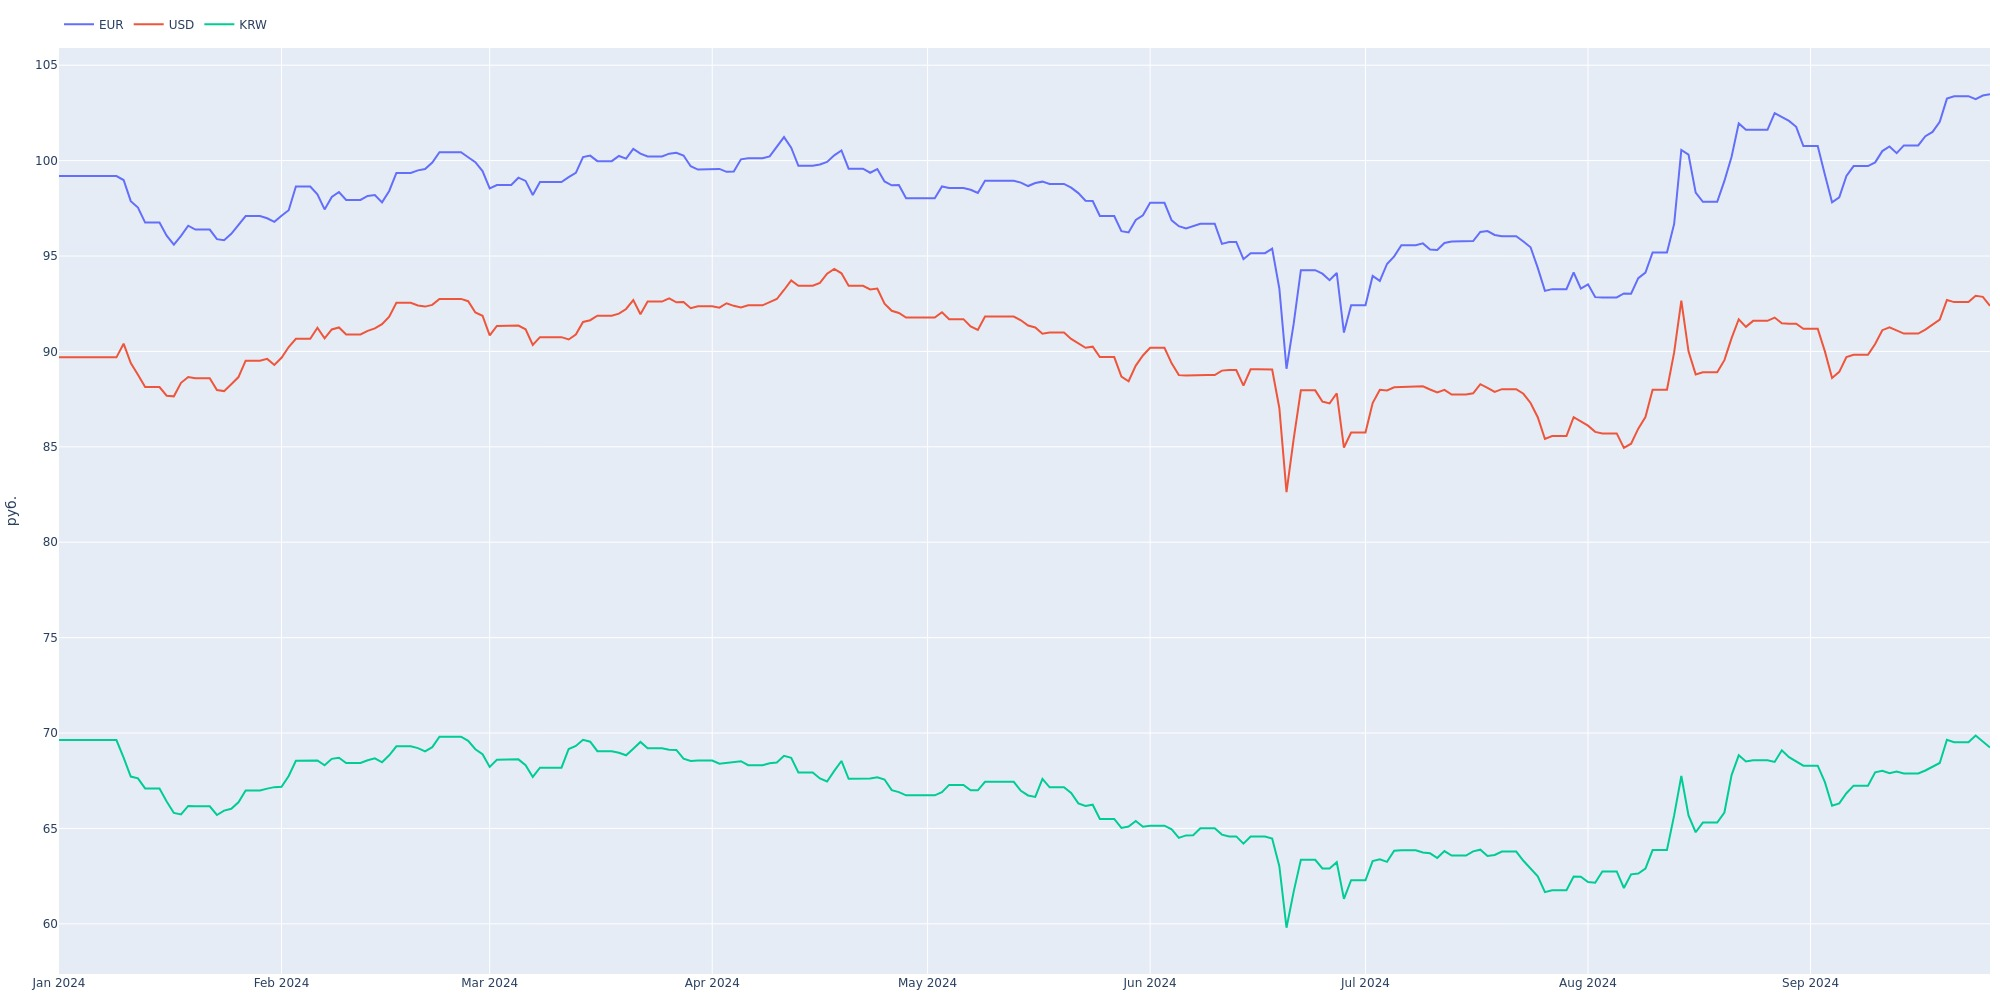

In [13]:
# Отображение в статичном режиме, если не отображается в ноутбуке
fig.show('jpg', width=2000, height=1000)

In [14]:
# Создание кросс-курса на основе доллара EUR/USD и KRW/USD
df['EUR/USD'] = df['EUR'] / df['USD']
df['KRW/USD'] = df['KRW'] / df['USD']

In [15]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.add_trace(go.Scatter(x=df['date'], y=df['EUR'], name='EUR'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['USD'], name='USD'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['KRW'], name='KRW'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['EUR/USD'], name='EUR/USD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['KRW/USD'], name='KRW/USD'), row=3, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                  height=800,
                  # width=1000
                )
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Курс: %{y:.2f}руб.', row=1, col=1)
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Курс: %{y:.2f}$.', row=2, col=1)
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Курс: %{y:.2f}$.', row=3, col=1)
fig.update_yaxes(title_text='руб.', row=1, col=1)
fig.update_yaxes(title_text='$', row=2, col=1)
fig.update_yaxes(title_text='$', row=3, col=1)

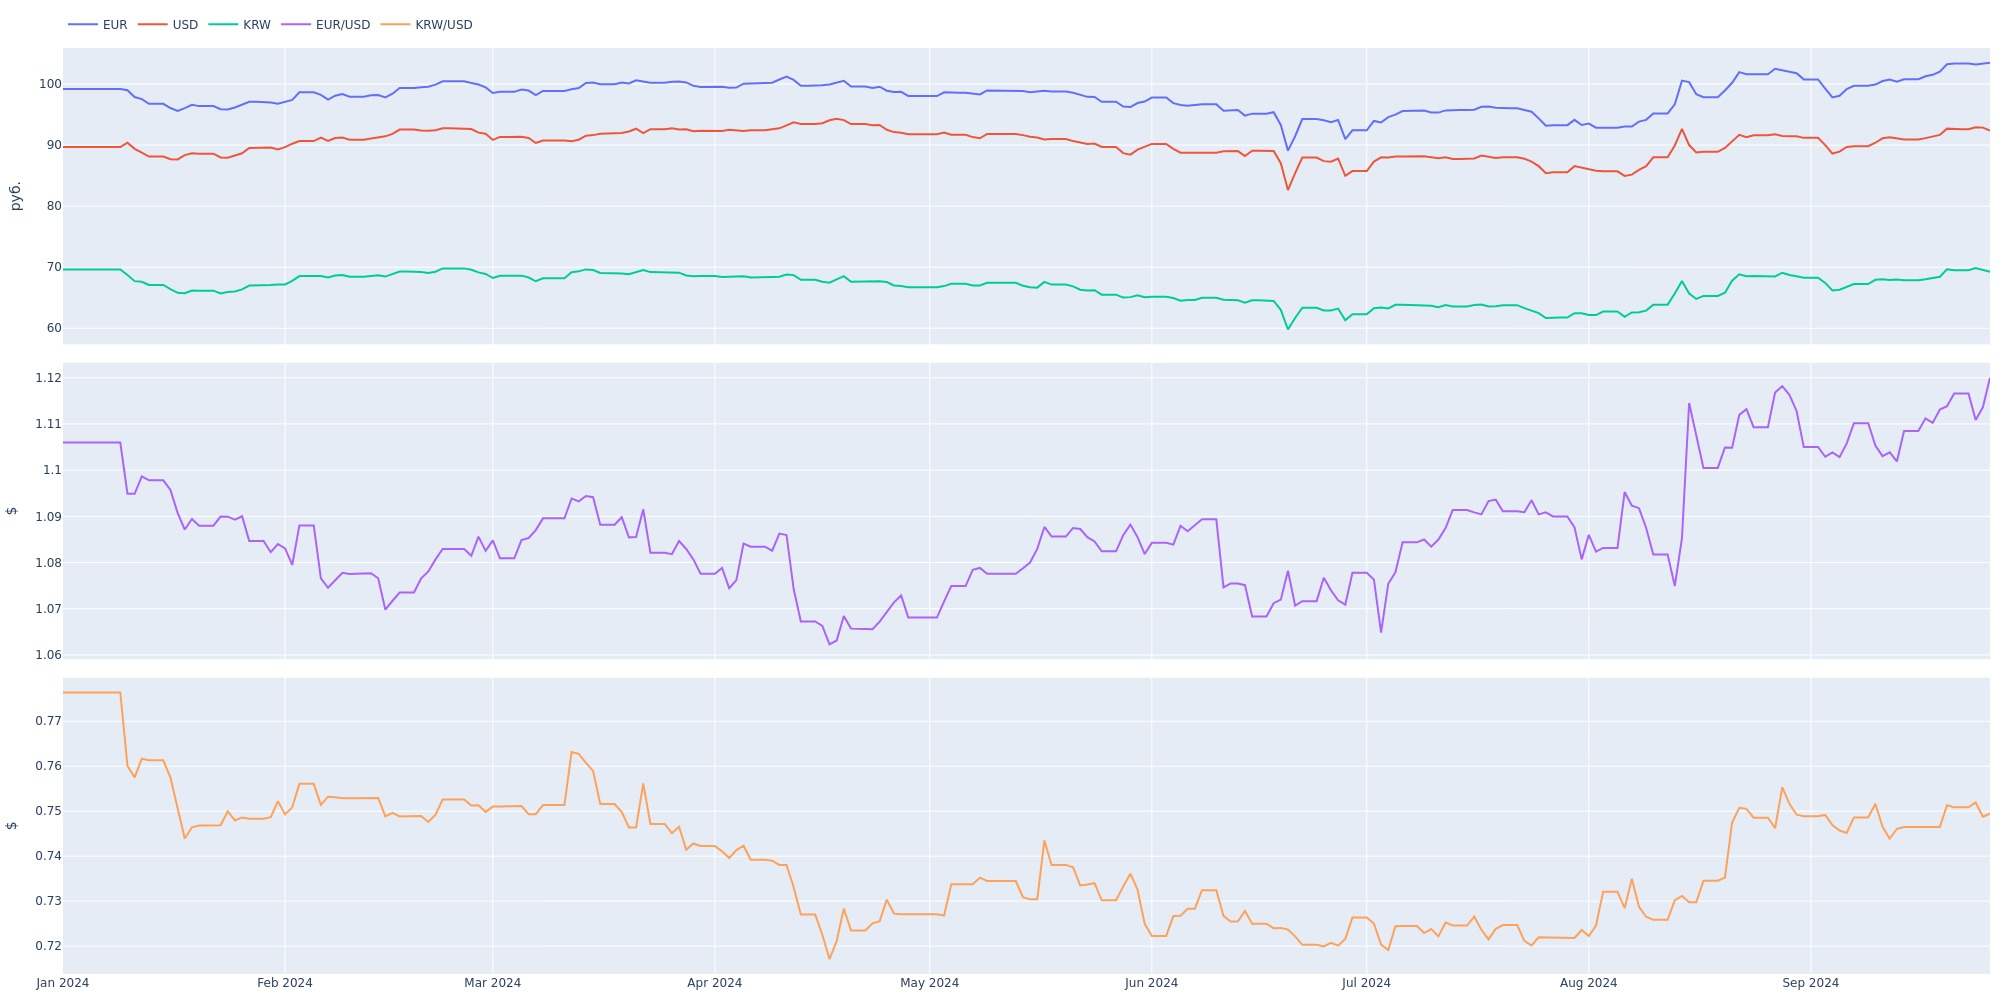

In [16]:
# Отображение в статичном режиме, если не отображается в ноутбуке
fig.show('jpg', width=2000, height=1000)

**Средний график (EUR/USD):**
- Кросс-курс EUR/USD демонстрирует снижение в начале года, указывая на ослабление евро относительно доллара. Затем наблюдается небольшой рост, что указывает на кратковременное восстановление евро по отношению к доллару.
- Летом курс колеблется, что свидетельствует о нестабильности на валютных рынках.

**Нижний график (KRW/USD):**
- Кросс-курс KRW/USD показывает долгосрочное снижение, особенно весной и летом, что указывает на ослабление южнокорейского вона относительно доллара. 
- Летом курс восстанавливается, но кросс-курс остается ниже уровней начала года.

<Axes: >

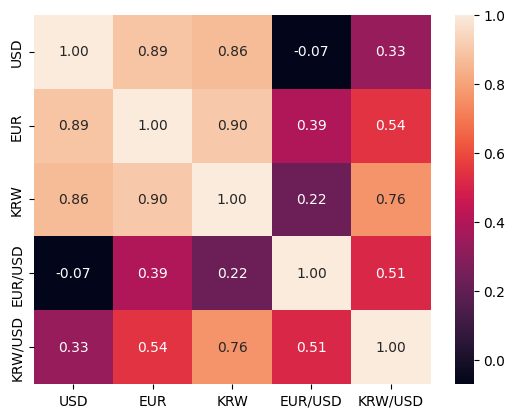

In [17]:
# тепловая карта корреляций
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

- USD и EUR сильно коррелируют с коэффициентом 0.89, что означает, что их курсы относительно рубля движутся в одном направлении, что логично, так как обе валюты зависят от глобальных макроэкономических условий.
- KRW также сильно коррелирует с USD и EUR (0.86 и 0.90 соответственно), что показывает синхронность движения с основными мировыми валютами.
- Кросс-курс EUR/USD имеет слабую отрицательную корреляцию с USD (-0.07), что указывает на то, что изменения курса евро относительно доллара не  совпадают с изменениями курса доллара относительно рубля.
- Кросс-курс KRW/USD имеет умеренную положительную корреляцию с USD и EUR, что указывает на зависимость KRW от динамики основных валют.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
currencies = ['USD', 'EUR', 'KRW', 'EUR/USD', 'KRW/USD']
metrics = pd.DataFrame(index=currencies, columns=['MSE', 'MAE', 'R2'])

# # Добавляем линии тренда для каждого столбца
X = np.arange(len(df['date'])).reshape(-1, 1)


for col in currencies:
    model = LinearRegression()
    y = np.array(df[col]).reshape(-1, 1)
    model.fit(X, y)
    df['trend_' + col] = model.predict(X)

    metrics['MSE'][col] = mean_squared_error(df[col], df['trend_' + col])
    metrics['MAE'][col] = mean_absolute_error(df[col], df['trend_' + col])
    metrics['R2'][col] = r2_score(df[col], df['trend_' + col])

metrics

,MSE,MAE,R2
USD,4.429491,1.784268,0.067763
EUR,6.538868,2.046677,0.004975
KRW,4.346665,1.735143,0.196797
EUR/USD,0.000146,0.009561,0.13226
KRW/USD,0.000142,0.009786,0.251829


1. Точность моделей для кросс-курсов лучше, чем для отдельных валют относительно рубля. Это можно объяснить тем, что кросс-курсы могут быть более стабильны, так как они отражают относительное изменение между двумя валютами, а не их взаимодействие с третьей (рублем).
2. Модели для USD, EUR и KRW относительно рубля имеют высокие значения ошибок (MSE и MAE) и низкие значения R², что указывает на слабое соответствие тренда реальным данным.
3. Для более точного предсказания валютных курсов относительно рубля, требуется более сложная модель, включающая дополнительные переменные, такие как макроэкономические показатели, цены на нефть и другие факторы.

In [20]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.add_trace(go.Scatter(x=df['date'], y=df['USD'], name='USD'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['trend_USD'], name='trend_USD', line=dict(dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['EUR'], name='EUR'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['trend_EUR'], name='trend_EUR', line=dict(dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['KRW'], name='KRW'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['trend_KRW'], name='trend_KRW', line=dict(dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['EUR/USD'], name='EUR/USD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['trend_EUR/USD'], name='trend_EUR/USD', line=dict(dash='dash')), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['KRW/USD'], name='KRW/USD'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['trend_KRW/USD'], name='trend_KRW/USD', line=dict(dash='dash')), row=3, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                  height=800,
                  # width=1000
                )
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Курс: %{y:.2f}руб.', row=1, col=1)
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Курс: %{y:.2f}$.', row=2, col=1)
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Курс: %{y:.2f}$.', row=3, col=1)
fig.update_yaxes(title_text='руб.', row=1, col=1)
fig.update_yaxes(title_text='$', row=2, col=1)
fig.update_yaxes(title_text='$', row=3, col=1)

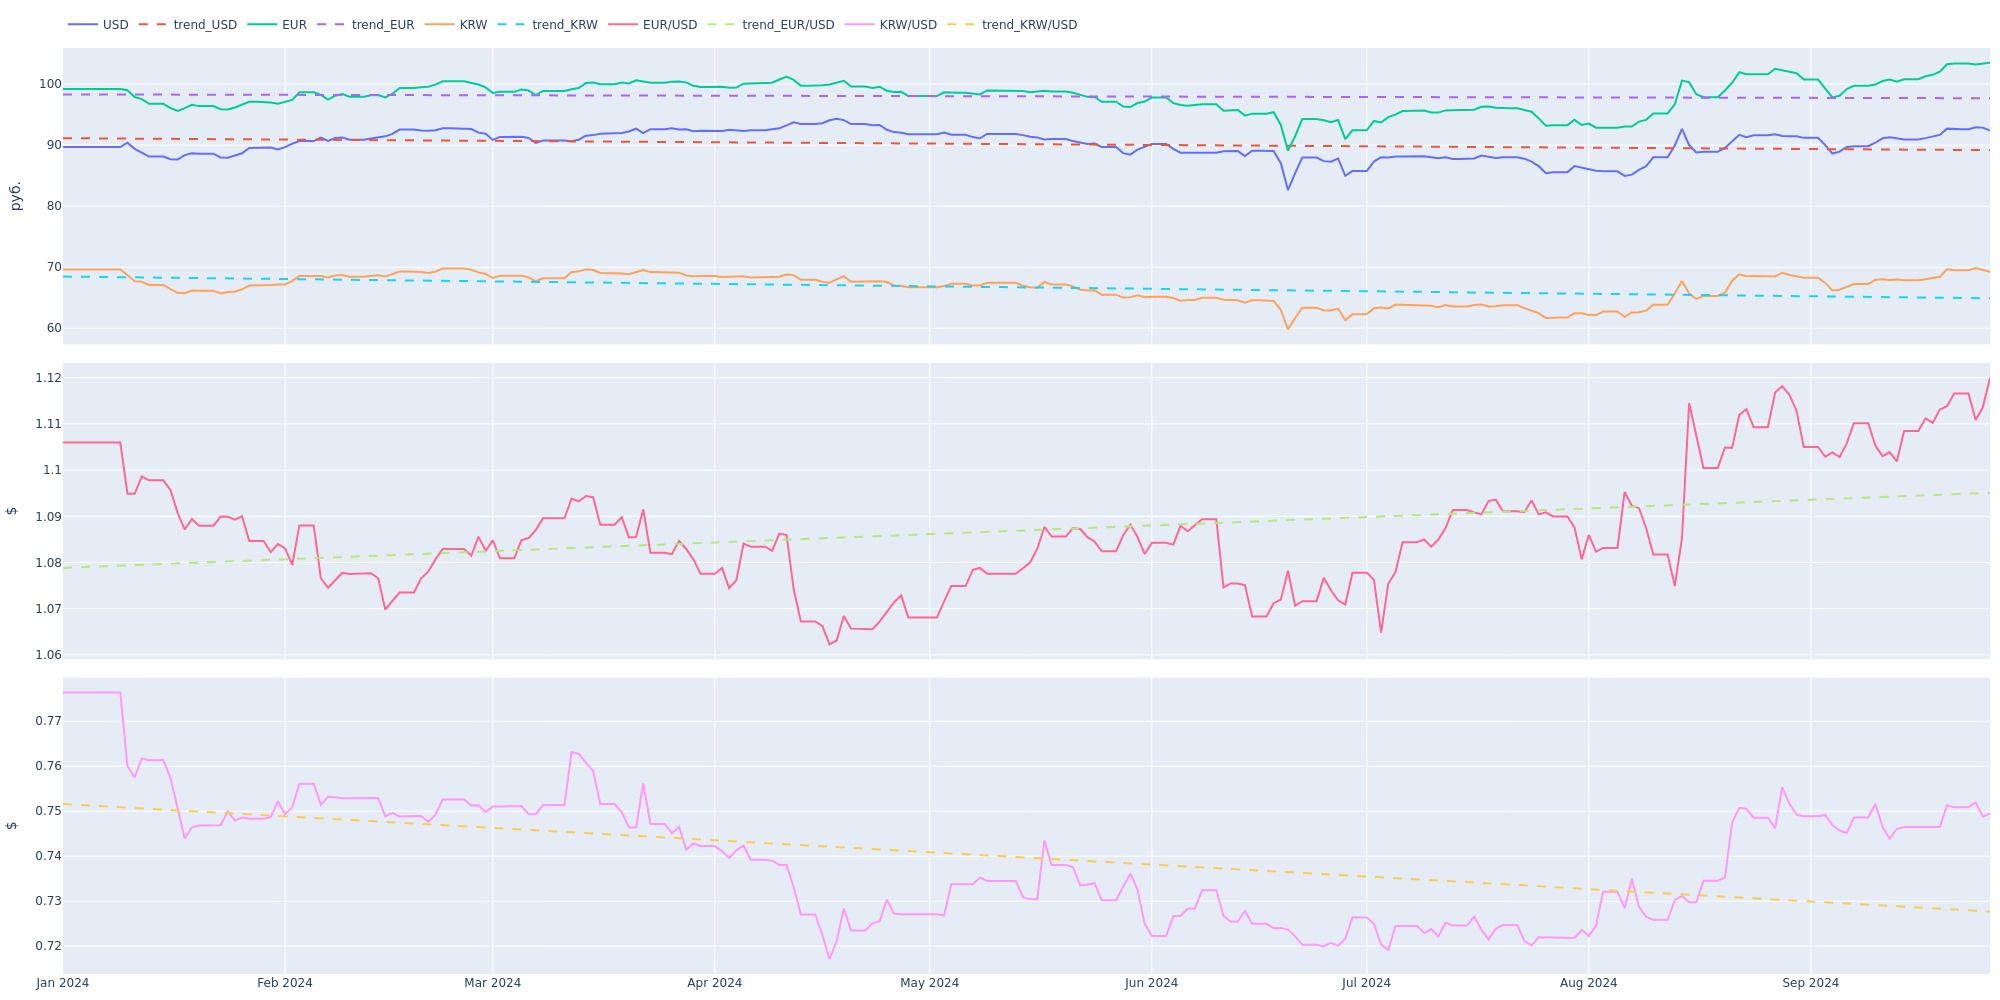

In [23]:
# Отображение в статичном режиме, если не отображается в ноутбуке
fig.show('jpg', width=2000, height=1000)

## Анализ трендов  
На предоставленном графике представлены как фактические курсы валют (USD, EUR, KRW) по отношению к рублю, так и их тренды. Также на графике изображены кросс-курсы EUR/USD и KRW/USD с соответствующими трендами. Внизу представлены кросс-курсы с трендами.

#### USD (доллар США):
   - Линия тренда USD — прерывистая красная линия — показывает незначительный спад, что указывает на небольшое ослабление доллара по отношению к рублю за исследуемый период.
   - Важно отметить, что незначительные колебания не отражают больших колебаний на рынке, что говорит о некоторой стабильности между этими валютами в течение этого времени.

#### EUR (евро):
   - Линия тренда EUR — фиолетовая прерывистая линия — слегка наклонена вниз, что указывает на незначительное ослабление евро по отношению к рублю.
   - Однако курс евро демонстрирует некоторое восстановление в последние месяцы, что можно заметить в виде резких колебаний в конце графика.

#### KRW (южнокорейский вон):
   - Линия тренда KRW — оранжевая прерывистая линия — показывает также незначительный спад, что указывает на общее ослабление южнокорейского вона по отношению к рублю.
   - На графике заметны краткосрочные резкие колебания курса в апреле и июле, что может указывать на региональные экономические изменения.

#### Кросс-курс EUR/USD:
   - Кросс-курс EUR/USD показывает движение в диапазоне 1.07–1.11 доллара за евро.
   - Линия тренда EUR/USD — зеленая прерывистая линия — демонстрирует небольшое понижение, что может свидетельствовать о незначительном укреплении доллара относительно евро за этот период.

#### Кросс-курс KRW/USD:
   - Линия тренда KRW/USD — желтая прерывистая линия — указывает на общее снижение курса KRW по отношению к USD.
   - На графике также заметен резкий рост в августе и сентябре, что может свидетельствовать о внешних факторах, влияющих на курс южнокорейского вона.



## Выводы:

1. **Летнее укрепление рубля**:
   - Вероятно, связано с сезонными факторами, включая налоговые поступления, возможное временное улучшение экспортных поступлений (особенно нефти и газа), а также внешнеэкономические условия.
   - Снижение курса USD и EUR в это время также может указывать на кратковременные действия Центрального банка России, направленные на поддержание курса рубля.

2. **Кросс-курсы EUR/USD и KRW/USD**:
   - Снижение курса EUR/USD в начале года указывает на глобальное укрепление доллара относительно евро.
   - KRW/USD показывает ослабление южнокорейского вона по отношению к доллару, особенно в первой половине года.

3. **Корреляции**:
   - Высокая корреляция между EUR, USD и KRW относительно рубля говорит о том, что валюты движутся синхронно в зависимости от глобальных экономических факторов и условий на валютном рынке.
   - Низкая корреляция кросс-курса EUR/USD с основными валютами подтверждает независимость движения этих двух валют относительно рубля и других факторов.

Таким образом, для более глубокого анализа можно рассмотреть макроэкономические события, произошедшие в середине года, чтобы определить точные причины укрепления рубля и динамики валют.

### Возможные объяснения:
- Макроэкономические факторы, такие как глобальные колебания цен на нефть и региональные экономические изменения, могут объяснять колебания валютных курсов.
- Монетарная политика центральных банков (в особенности ФРС для USD, ЕЦБ для EUR и Центрального банка Кореи для KRW) также оказывает влияние на тренды, особенно если принимаются решения по изменению процентных ставок.
- Сезонные колебания могут объяснять резкие движения летом, которые видны на кросс-курсах и валютных курсах относительно рубля.


- Рубль стабилен относительно основных валют (USD, EUR, KRW) в течение исследуемого периода. Однако тренды показывают небольшое ослабление рубля по отношению к этим валютам.
- EUR/USD и KRW/USD демонстрируют тенденции к укреплению доллара на мировом рынке, что подтверждается нисходящими линиями трендов для этих кросс-курсов.
- KRW наиболее волатилен среди рассмотренных валют, что может быть связано с региональными экономическими факторами и влиянием глобальных событий.
